# NN on plane sums

In [1]:
import numpy as np
from matplotlib import pylab as plt

In [2]:
import src.operate_datasets    as operate_datasets
import src.model_visualisation as model_visualisation
import src.model_evaluation    as model_evaluation

Welcome to JupyROOT 6.18/00


## Load data

In [3]:
full_X, full_y = operate_datasets.load_dataset('~/snd_data/new_dataset/', 'longitudal')

X_train, y_train, X_test, y_test = operate_datasets.split_dataset(full_X, full_y)

In [4]:
X_train.shape

(108000, 13)

In [5]:
#X_train = X_train.reshape(-1, 1)
#y_train = y_train.reshape(-1, 1)

In [6]:
min_clip = 0
#X_train, y_train = operate_datasets.clip_dataset(X_train, y_train, min_clip)

## Fit model

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import constraints
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [8]:
X_tens = torch.tensor(X_train).float()
y_tens = torch.tensor(y_train).float()

X_test_tens = torch.tensor(X_test).float()
y_test_tens = torch.tensor(y_test).float()

In [9]:
X_tens.shape

torch.Size([108000, 13])

In [10]:
def train_iteration(model, optimizer, loss_fn, x_data, y_data):
    y_pred = model(x_data).squeeze(-1)
    loss = loss_fn(y_pred, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [11]:
class NN(nn.Module):
    def __init__(self, inp_dim, hid_dim):
        super().__init__()
        self.fc1 = nn.Linear(inp_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, hid_dim)
        self.fc3 = nn.Linear(hid_dim, 1)

    def forward(self, x, y=None):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
def run_training(num_iter):
    model = NN(X_tens[0].shape[0], 32) # PyroModule[nn.Linear](1, 1)
    loss_fn = torch.nn.MSELoss(reduction='sum')
    
    loss_arr  = []

    optim = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = ReduceLROnPlateau(optim, 'min', factor=0.5, patience=25, verbose=True, threshold=1e-2)

    for j in range(num_iter):
        loss = train_iteration(model, optim, loss_fn, X_tens, y_tens)

        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
            
        scheduler.step(loss)
        loss_arr.append(loss.item())
        
    return model, loss_arr

In [13]:
model, loss_arr = run_training(1000)

[iteration 0050] loss: 19202.0742
[iteration 0100] loss: 6495.6924
[iteration 0150] loss: 4447.8672
[iteration 0200] loss: 3898.3740
[iteration 0250] loss: 3602.8154
[iteration 0300] loss: 3417.0891
[iteration 0350] loss: 3280.6951
[iteration 0400] loss: 3165.7236
[iteration 0450] loss: 3067.8462
[iteration 0500] loss: 2985.7192
[iteration 0550] loss: 2918.4038
Epoch   594: reducing learning rate of group 0 to 5.0000e-03.
[iteration 0600] loss: 2866.0798
Epoch   622: reducing learning rate of group 0 to 2.5000e-03.
Epoch   648: reducing learning rate of group 0 to 1.2500e-03.
[iteration 0650] loss: 2848.5903
Epoch   674: reducing learning rate of group 0 to 6.2500e-04.
[iteration 0700] loss: 2844.0854
Epoch   700: reducing learning rate of group 0 to 3.1250e-04.
Epoch   726: reducing learning rate of group 0 to 1.5625e-04.
[iteration 0750] loss: 2842.8621
Epoch   752: reducing learning rate of group 0 to 7.8125e-05.
Epoch   778: reducing learning rate of group 0 to 3.9063e-05.
[iterati

In [14]:
y_pred = model(torch.Tensor(X_train)).detach().cpu().numpy().squeeze(-1)

In [15]:
y_pred

array([0.29031357, 0.13383949, 0.39519197, ..., 0.2615364 , 0.23318064,
       0.23883945], dtype=float32)

## Visualise results

In [16]:
X_sum = X_train.sum(axis=1).reshape(-1,1)

In [17]:
y_train = y_train.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)

In [18]:
model_name = 'NN on plane sums'
save_file_prefix = model_name.replace(' ', '-')

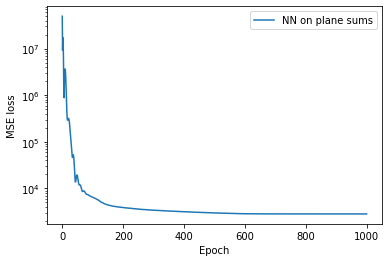

In [19]:
def plot_loss_arrays(loss_dict):
    for key in loss_dict.keys():
        plt.plot(loss_dict[key][0:], label=key)
    
    plt.yscale('log')
    #plt.xscale('log')
    plt.ylabel('MSE loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    return
    
plot_loss_arrays({model_name : loss_arr})

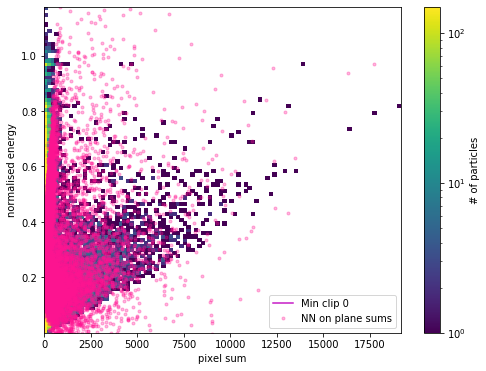

In [20]:
model_visualisation.plot_2d_energy_hist_clip(X_sum, y_train, y_pred, 0, model_name,
                                             save_file_prefix=save_file_prefix) 

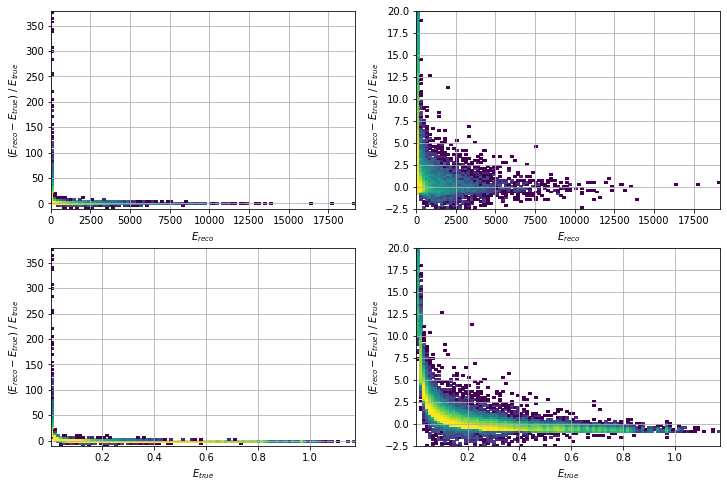

In [21]:
model_visualisation.plot_res_vs_energy(X_sum, y_train, y_pred, vmax=450,
                                       save_file_prefix=save_file_prefix) 

mean   = 1.48908e+00
std    = 5.64484e+00
median = 2.89011e-01


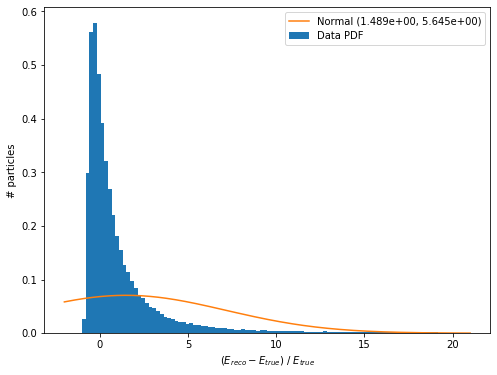

In [22]:
model_visualisation.plot_res_hist_fit(y_train, y_pred, [-1,20],
                                      save_file_prefix=save_file_prefix)

In [23]:
model_evaluation.save_scores(y_train, y_pred, save_file_prefix)

explained_variance_score 0.177363892870124
max_error 2.611687150400545
mean_absolute_error 0.11787348753543414
mean_squared_error 0.02631846155314021
median_absolute_error 0.09478906930524655
r2_score 0.177361631617573


,NN-on-plane-sums
explained_variance_score,0.177364
max_error,2.611687
mean_absolute_error,0.117873
mean_squared_error,0.026318
median_absolute_error,0.094789
r2_score,0.177362
avg_resolution,1.489076
std_resolution,5.644837


## Validation

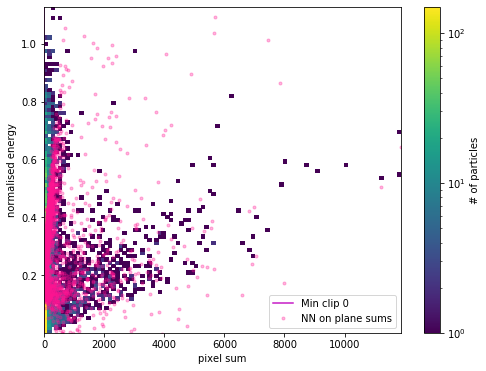

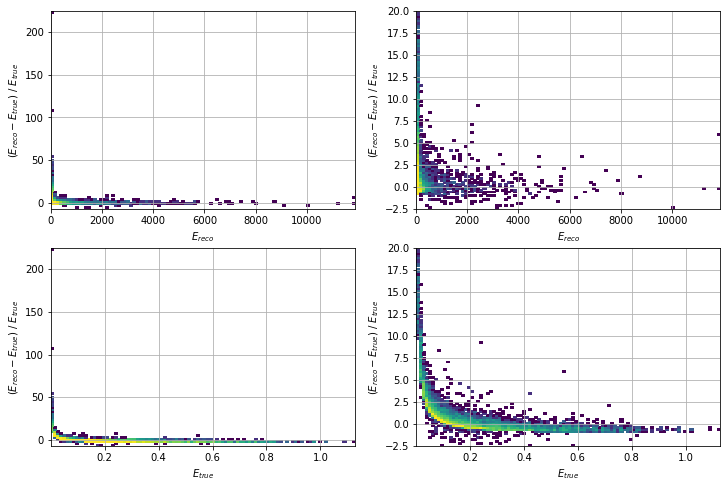

mean   = 1.40698e+00
std    = 4.32708e+00
median = 2.85151e-01


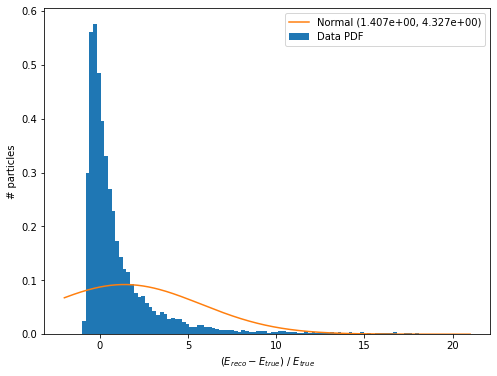

explained_variance_score 0.12373118344018552
max_error 3.245610660418611
mean_absolute_error 0.11862782227915936
mean_squared_error 0.027946827705677104
median_absolute_error 0.09502740431542053
r2_score 0.12371444367487094


,NN-on-plane-sums
explained_variance_score,0.123731
max_error,3.245611
mean_absolute_error,0.118628
mean_squared_error,0.027947
median_absolute_error,0.095027
r2_score,0.123714
avg_resolution,1.406977
std_resolution,4.327076


In [24]:
X_sum = X_test.sum(axis=1).reshape(-1,1)

#X_test = X_test.reshape(-1,1)
y_test = y_test.reshape(-1,1)

y_pred_test = model(X_test_tens).detach().numpy().reshape(-1,1)


model_visualisation.plot_2d_energy_hist_clip(X_sum, y_test, y_pred_test, min_clip, model_name,
                                             save_file_prefix=save_file_prefix) 

model_visualisation.plot_res_vs_energy(X_sum, y_test, y_pred_test, vmax=150,
                                       save_file_prefix=save_file_prefix)  

model_visualisation.plot_res_hist_fit(y_test, y_pred_test, [-1,20],
                                      save_file_prefix=save_file_prefix)

model_evaluation.save_scores(y_test, y_pred_test, save_file_prefix, 
                             folder_path=model_evaluation.TEST_SCORES_DIR)